Relatório do trabalho
==============
**Nome:** Álvaro Leandro Cavalcante Carneiro
**Linguagem utilizada:** Python 3.6

Os códigos e o relatório foram desenvolvidos em um Jupyter notebook e sua versão online pode ser encontrada aqui: https://colab.research.google.com/drive/1HQIBTnHCrcSrfAUOsx7836wZzDnQ9Fhd?usp=sharing. Nessa versão é possível executar novamente os algoritmos.

# Qual o problema ? 
Utilizar uma rede neural no modelo perceptron para identificar 3 classes de flores baseados em suas características de tamanho de pétalada e sépala.

## Importação das bibliotecas
Ferramentas usadas no processo de desenvolvimento

In [73]:
import random
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import itertools

# Análise Exploratória dos Dados (AED)
A ideia a princípio é entender um pouco mais do *dataset* e deixar os dados em um formato que seja favorável para o aprendizado da rede neural perceptron.

O primeiro passo foi ler o arquivo baixado aqui: http://archive.ics.uci.edu/ml/datasets/Iris.
O arquivo em questão não possuia colunas, portanto eu modifiquei o mesmo para adicionar o nome das colunas na primeira linha e deixá-lo no formato .CSV ao invés do .DATA.

O *dataset* está sendo lido com o método *read_csv* do pandas, que transforma o conjunto de dados em um *dataframe*, que por sua vez possui diversos métodos nativos para manipular os dados. Um desse métodos é o *head*, onde é possível visualizar as primeiras linhas do *dataframe*.

In [74]:
dataframe = pd.read_csv('/home/alvaro/Documentos/mestrado/computação bio/redes neurais/datasets/iris2.csv', header = 0)

dataframe.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Um pré-requisito na mineração dos dados é verificar se o *dataframe* possui inconsistências quanto aos valores, podendo ser algum outlier, ruído, valor vazio, etc...

Para isso, é utilizado o método *isna* para contabilizar os registros vazios por coluna e também o método *describe* que gera um sumário por coluna dos valores ali contidos.

In [75]:
print('Valores nulos:')
print(dataframe.isna().sum())
dataframe.describe()

Valores nulos:
sepal-length    0
sepal-width     0
petal-length    0
petal-width     0
class           0
dtype: int64


,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Mostrando a dispersão dos dados
É interessante também plotar um gráfico para mostrar o comportamento da dispersão das classes do conjunto, sendo possível inclusive ver se o problema é linearmente separável.

Antes disso, é necessário dividir o *dataframe* em uma variável chamada **previsores** e outra chamada **classe**. Como o nome sugere, os previsores são as colunas com as características das flores (atributos previsores) que serão utilizados para tentar ajustar os pesos da rede de maneira à generalizar uma solução que encontre as classes corretamente.

In [76]:
previsores = dataframe.iloc[:, 0:4] 
classe = dataframe['class']

<Figure size 432x288 with 0 Axes>

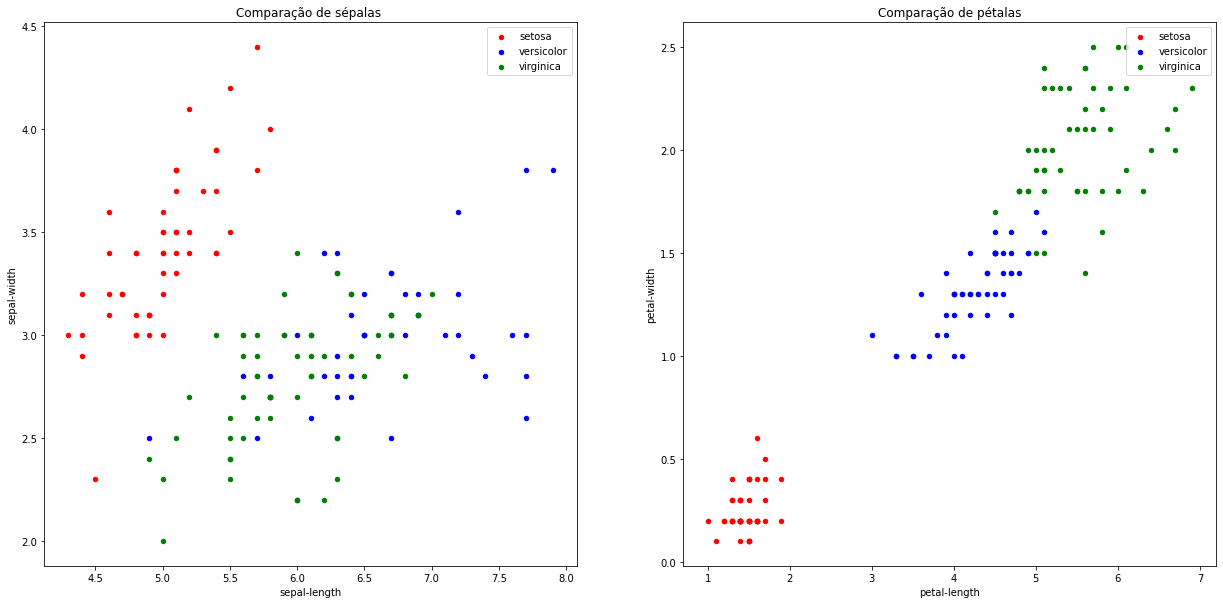

In [77]:
# iniciando a figura
plt.figure()
fig,ax=plt.subplots(1,2,figsize=(21, 10))

# separando o dataset por classe
setosa = dataframe[dataframe['class']=='Iris-setosa']
versicolor = dataframe[dataframe['class']=='Iris-versicolor']
virginica = dataframe[dataframe['class']=='Iris-virginica']

# plotando os conjuntos no gráfico de dispersão
setosa.plot(x="sepal-length", y="sepal-width", kind="scatter",ax=ax[0],label='setosa',color='r')
virginica.plot(x="sepal-length",y="sepal-width",kind="scatter",ax=ax[0],label='versicolor',color='b')
versicolor.plot(x="sepal-length", y="sepal-width", kind="scatter", ax=ax[0], label='virginica', color='g')

setosa.plot(x="petal-length", y="petal-width", kind="scatter",ax=ax[1],label='setosa',color='r')
versicolor.plot(x="petal-length",y="petal-width",kind="scatter",ax=ax[1],label='versicolor',color='b')
virginica.plot(x="petal-length", y="petal-width", kind="scatter", ax=ax[1], label='virginica', color='g')
# Adicionado legendas
ax[0].set(title='Comparação de sépalas ', ylabel='sepal-width')
ax[1].set(title='Comparação de pétalas',  ylabel='petal-width')
ax[0].legend()
ax[1].legend()
plt.show()

Podemos ver que as classes virgínica e versicolor são as mais complicadas de serem separadas, principalmente quando olhamos para o tamanho das pétalas.

## Normalização dos atributos previsores
O método *isnul()* mostrou que não há nenhum registro vazio no nosso *dataset* e é possível observar que os valores também parecem estar todos coerentes, sem a presença de outliers, como podemos notar pelo desvio padrão, mínimo e máximo de cada coluna e também no gráfico de dispersão.

Todavia, existe uma variação relativamente grande dentro do nosso domínio de atributos previsores. O atributo *petal-width* por exemplo, tem uma média de valor de 1.1, enquanto o *sepal-length* possui uma média de 5.8. Dito isso, se faz necessário a padronização desses valores, para que nosso ajuste dos pesos não seja muito influenciado por essa diferença no tamanho da entrada. 

O tipo de normalização escolhido foi o **Z-score**, de forma arbitrária, por ser bastante comum em problemas como esse. Sua fórmula é bastante simples e foi representada no método *normalizacao_z_score*.

In [78]:
def normalizacao_z_score(valor):
    media = previsores[valor.name].mean()
    desvio_padrao = previsores[valor.name].std()

    return (valor - media) / desvio_padrao

O método *apply()* do pandas juntamente com a **lambda** aplicam o processo matemático do método de normalização em cada um dos registros do *dataframe*. Os novos registros normalizados podem ser vistos abaixo.

In [79]:
previsores = previsores.apply(lambda row: normalizacao_z_score(row))
previsores.head()

,sepal-length,sepal-width,petal-length,petal-width
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593
2,-1.380727,0.336720,-1.393470,-1.308593
3,-1.501490,0.106090,-1.280118,-1.308593
4,-1.018437,1.259242,-1.336794,-1.308593


## Tratando valores categóricos
O próximo passo será transformar o valor da classe de categórico para discreto, para que seja possível aplicar os cálculos, como o erro da saída por exemplo.

Para isso foi criado o método *get_dicionario_classes* que gera uma estrutura de dicionário dinâmica, baseado na quantidade de classes do problema que está sendo tratado. O processo é muito simples, basta percorrer a classe existente e atribuir um valor inteiro para cada classe.

In [80]:
def get_dicionario_classes(classe):
    dict_classes = {}
    count = 0
    
    for i in classe.unique():
        dict_classes[i] = count
        count += 1
        
    return dict_classes

In [81]:
dict_classes = get_dicionario_classes(classe)
print(dict_classes)

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


Podemos ver acima os valores que nosso método atribuiu para cada uma das classes.

Basta agora repetir o processos anterior de usar o método *apply()*, porém agora passando no *lambda* o método que vai atribuir a classe a seu determinado valor no dicionário que criamos anteriormente.

In [82]:
def transformar_categorico_em_numerico(valor, dict_classes):
    return dict_classes[valor]
    
classe = classe.apply(lambda row: transformar_categorico_em_numerico(row, dict_classes))
print(classe.value_counts())

2    50
1    50
0    50
Name: class, dtype: int64


## Lidando com problemas multi-classe
O problema em questão é multi-classe, ou seja, possuímos mais de duas classes como resposta na camada de saída, podendo ser, íris-setosa, versicolor ou virginica.
Para problemas binários utilizar um único neurônio com a saída de 0 e 1 nos basta, todavia aqui, vamos precisar criar um novo neurônio para cada classe, totalizando 3 na nossa camada de saída.

Além de modificar a estrutura da rede neural, também vamos precisar codificar nossos valores, uma vez que, ao invés de um valor escalar vamos trabalhar com um array na saída da rede, sendo ele representado por: [1,0,0], [0,1,0] e [0,0,1].

In [83]:
def codificar_classe():
    classe_codificada = {}
    array_classe = [1] + [0] * (len(classe.unique()) - 1) #cria um array dinâmico baseado na 
    #quantidade de classes, é [1,0,0] para esse problema mas poderia ser [1,0,0,0....,0].
    count = 1    
    classe_codificada[0] = array_classe.copy()
    
    for i in range(len(classe.unique()) - 1): # percorre todas as classes -1, pois já temos a primeira posição do dicionário por padrão
        array_classe[count - 1] = 0 # o valor 1 atual vira 0
        array_classe[count] = 1  # a próxima casa do array vira 1   
        classe_codificada[count] = array_classe.copy()
        count += 1
    
    return classe_codificada      

classe_codificada = codificar_classe()

In [84]:
classe_codificada

{0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]}

A ideia do método *codificar_classe* é criar mais um dicionário, como podemos ver acima, onde cada posição representa uma classe codificada em um array de binários. O tamanho desse array é dinâmico dependendo do número de classes e a ideia é ir movimentando o valor do 1 conforme as iterações.

Feito isso, basta repetir o processo para substituir o valor da classe.

In [85]:
def substituir_classe_codificada(valor, classe_codificada):
    return classe_codificada[valor]

classe = classe.apply(lambda row: substituir_classe_codificada(row, classe_codificada))
print(classe.head())

0    [1, 0, 0]
1    [1, 0, 0]
2    [1, 0, 0]
3    [1, 0, 0]
4    [1, 0, 0]
Name: class, dtype: object


Com isso, a classe agora está em uma estrutura que vai suportar o problema multi-classe.

## Divisão do dataframe
Agora que os dados do *dataframe* já estão no formato necessário, basta dividir as bases em treinamento, validação e teste, usando a proporção de 70%, 15% e 15%.

Para isso foi criado o método *dividir_dataframe* onde iremos utilizar o método *sample* do pandas para pegar amostras aleatórias sem reposição do nosso dataframe, e a partir dessa amostra iremos criar os outros conjuntos.

O *x_treinamento* vai ser a fatia responsável por treinar a rede e ajustar os pesos. O teste do treinamento será feito ao final de cada época na base chamada *x_teste*, nos dando uma avaliação não enviesada dos resultados da rede em dados não vistos no treino.

Após a rede estar completamente treinada, iremos usar a base de *x_validacao* para gerar novas previsões baseado em atributos previsores nunca antes vistos pela rede, nos dando uma validação final da eficácia do treinamento.

In [86]:
def dividir_dataframe(previsores, classe, p_treinamento, p_teste, p_validacao, epoca = False):
    x_treinamento = previsores.sample(frac = p_treinamento)
    y_treinamento = classe[x_treinamento.index]
    
    x_teste_sem_previsores = previsores.drop(x_treinamento.index)
    nova_p_teste = p_teste / (1 - p_treinamento)
    
    x_teste = x_teste_sem_previsores.sample(frac = nova_p_teste)
    y_teste = classe[x_teste.index]
    
    x_validacao = x_teste_sem_previsores.drop(x_teste.index)
    y_validacao = classe[x_validacao.index]
    
    if epoca == False:
        return x_treinamento.reset_index(drop=True), y_treinamento.reset_index(drop=True), \
        x_teste.reset_index(drop=True), y_teste.reset_index(drop=True), x_validacao.reset_index(drop=True), y_validacao.reset_index(drop=True)
    else:
        # não tem reset index na classe
        return x_treinamento.reset_index(drop=True), y_treinamento, \
        x_teste.reset_index(drop=True), y_teste, x_validacao.reset_index(drop=True), y_validacao

Estou usando a nomenclatura de "x" para me remeter à atributos previsores e "y" para classe.

Depois de criar a fração de treinamento, eu removo dos meus previsores todos os dados que estão na porção de treinamento, pois uma regra importante a ser seguida na divisão dos dados é o particionamento, ou seja, nenhum dos registros de treinamento deve estar no conjunto de teste e vice versa. 

Depois disso, meu conjunto total se torna o resto que não está no conjunto de treinamento, portanto as porcentagens também são redimensionadas, por exemplo, se antes tinhamos 15% do nosso conjunto para treinamento e 15% para validação, agora cada um desses 15% representa 50%, pois o novo 100% está sem os registros de treinamento.

Feito isso, basta dividir novamente a base em teste e validação e retornar os valores.

## Inicialização dos pesos
Os pesos serão inicializados de forma aleatória para então serem gradativamente ajustados conforme a rede neural converge.
Para isso, foi criado o método *inicializar_pesos*, que percorre cada um dos neurônios e gera um vetor da quantidade de pesos que ele possui baseado nas suas conexões sinapticas com os neurônios da próxima camada.

Além disso, nosso método também recebe um parâmetro chamado dominio, que é o intervalo de valores que os pesos serão gerados, os testes a princípio foram realizados em um domínio de [0,1].

In [87]:
def inicializar_pesos(dominio):
    pesos_final = []
    
    for i in range(len(previsores.columns)):
        pesos = [] 
        for j in range(len(dict_classes)):
            pesos.append(random.uniform(dominio[0], dominio[1]))
        pesos_final.append(pesos)
    return pesos_final

In [88]:
pesos = inicializar_pesos([0, 1])
print('Pesos:', pesos)

Pesos: [[0.026887243420132823, 0.452105311311334, 0.58884517218573], [0.21442767551305986, 0.4954708279390403, 0.934681047780013], [0.8717397358803461, 0.8004007879256287, 0.5226217516321491], [0.5564059744783354, 0.16990495627141577, 0.46632247750470646]]


Como podemos ver acima, o array de pesos para esse problema possui 4 posições com 3 pesos em cada uma das posições, isso acontece por que possuímos 4 neurônios (nosso atributos de entrada/previsores sem considerar o bias nesse caso) conectados à 3 neurônios (um neurônio para cada saída possível), portanto cada um dos 4 neurônios possui 3 pesos (conexões) cada um. 

Para obter o número de conexões por camada basta multiplicar o número de neurônios da camada atual pelos número de neurônios na próxima camada, dessa forma temos: 4 * 3 = 12.

## Implementação da função de soma
A função de soma acontece em todos os neurônios, somando o valor do produto da multiplicação entre os neurônios adjacentes anteriores com os pesos das sinapses artificiais.
Esse valor de soma é o valor final do nosso neurônio após receber todas as sinapses e será usado na função de ativação para indicar se o neurônio em questão foi excitado ou inibido.


A soma do produto pode ser feita de forma simples usando o método *dot* do numpy, retornando um produto escalar.

In [89]:
def somatoria(entradas, pesos):
    return np.dot(entradas, pesos) 

## Função de ativação
A função de ativação por default no perceptron é a chamada "step function (função degrau)", onde o neurônio artificial é excitado ou não baseado em um threshold (limiar) pré definido.
Nesse caso, se o valor do neurônio for maior que 0 ele retorna o 1, excitando a célula, caso contrário, retorna 0.

Por ser um problema multiclasse, foi criado um *for* para percorrer o array da classe e excitar todas as posições em que o valor é maior que 0. 

Claro que isso acaba gerando um problema onde mais de um neurônio por vez na camada de saída pode ser excitado. 

In [90]:
def funcao_ativacao_step(soma):
    ativacao = []
    for i in soma:
        if i > 0:
            ativacao.append(1)
        else:
            ativacao.append(0)

    return ativacao, ativacao

## Função de custo
A função de custo é a responsável por calcular o erro da rede neural ao comparar o valor correto com o valor que foi previsto.

A variável de *erro* indica se a rede neural errou a previsão ou acertou (uma vez que os pesos aqui não serão atualizados em caso de acerto), já a variável *valor_erro*, nos indica o valor exato em cada neurônio de saída que a rede classificou incorretamente, para ter uma precisão maior na atualização dos pesos.

Por exemplo, se o valor previsto foi: [0.8,0.37,0.16] e o valor real é: [0,1,0], a variável *valor_erro* vai trazer o erro do algoritmo por posição: [0.8, 0.63, 0.16], totalizando uma soma de 1.59. 

In [91]:
def funcao_custo(valor_correto, valor_previsto, valor_ativacao):
    erro = valor_correto != valor_previsto
    valor_erro = list(abs(np.array(valor_correto) - np.array(valor_ativacao)))
    return erro, sum(valor_erro) # valor escalar

## Função de atualização de peso
A formula da atualização de pesos no perceptron foi representada no método de *atualizar_peso*

Com ela, conseguimos ajustar os pesos seguindo uma taxa de aprendizado (basicamente o tamanho do "passo") além de levar em consideração a grandeza da entrada e o quanto a previsão estava incorreta.

Algo importante de se considerar é que o perceptron faz a atualização dos pesos POR REGISTRO, ou seja, a cada registro apresentado a rede neural que é classificado de forma incorreta gera uma atualização nos pesos, podendo dificultar a convergência devido à sensibilidade aos dados contidos no *dataframe*.

In [92]:
def atualizar_peso(entrada, peso, erro, tx_aprendizado):
    novo_peso = peso + (tx_aprendizado * entrada * erro)
    return novo_peso

## Bias
O Bias é a constante que iremos adicionar como sendo uma das colunas do *dataframe*. Essa coluna, assim como as demais, irá se transformar em um neurônio da rede, que vai ajudar nos cálculos dos pesos.

O Bias tem uma atualização diferentes dos demais, pois não leva em consideração a entrada, portanto foi criado um método para atualizar o bias.

In [93]:
def atualizar_bias(entrada, peso, erro, tx_aprendizado):
    novo_peso = peso + np.float64(tx_aprendizado * erro)
    return novo_peso

In [94]:
previsores['bias'] = 1

## Implementação do perceptron
O método *treinar* é que a que vai implementar de fato todas as etapas que foram mostradas até agora, recebendo o número de épocas que iremos executar o perceptron, onde cada época representa a passagem de todo o *dataframe* na pela rede. Passamos também a função de ativação que será utilizada, a função de custo e os conjuntos de treinamento e teste, além da taxa de aprendizado. 

In [95]:
def treinar(epocas, f_ativacao, f_custo, pesos, x_treinamento, y_treinamento, x_teste, y_teste,
           tx_aprendizado):

    execucoes = 0
    precisoes_treinamento = [] #convergência da base de treinamento ao longo das épocas
    precisoes_teste = [] # convergência da base de teste ao longo das épocas
    melhores_pesos = [] # registra o melhor conjunto de pesos para a validação posterior

    while execucoes < epocas: # parada ao executar todas as épocas.
        precisao = 0
        iteracao = 0
        # x_treinamento = x_treinamento.sample(frac=1).reset_index(drop=True) # embaralhar os valores dos previsores, por que sem isso, podemos ter sempre uma ordem fixa de ajuste de pesos, prejudicando a rede

        for i in x_treinamento.values: # percorre cada registro individualmente
            entradas = i   
            soma = somatoria(entradas, pesos)
        
            # a ativacao retorna qual dos 3 neurônios de saíde foram excitados e também o 
            # valor real da ativação, para calculo do erro.
            neuronio_excitado, valor_ativacao = f_ativacao(soma) 
        
            erro, valor_erro = f_custo(y_treinamento[iteracao], neuronio_excitado, 
                                       valor_ativacao)
            # atualiza os pesos em caso de erro
            if erro == True:
                count = 0
                # percorre cada coluna para atualizar o peso e o bias
                for i in entradas:
                    if count == len(entradas) - 1:
                        novo_peso = atualizar_bias(i, pesos[count], valor_erro, tx_aprendizado)
                    else:
                        novo_peso = atualizar_peso(i, pesos[count], valor_erro, tx_aprendizado)
                    
                    pesos[count] = novo_peso
                    count += 1
            else:
                precisao += 100 / len(x_treinamento)

            iteracao += 1
        
        precisoes_treinamento.append(precisao)
        melhores_pesos = pesos.copy() if precisoes_treinamento[execucoes] >= max(precisoes_treinamento) else melhores_pesos

        precisoes_teste.append(testar(pesos, x_teste, y_teste, f_ativacao, f_custo))
        execucoes += 1
    return precisoes_treinamento, precisoes_teste, melhores_pesos

## Método de teste
Ao final de cada época a rede teve seu desempenho avaliado na base de teste, isso foi feito no método *testar* onde usamos os pesos ajustados no treinamento apenas para pegar os acertos e erros no conjunto de teste.

In [96]:
def testar(pesos, x_previsores, y_classe, f_ativacao, f_custo):
    precisao = 0
    iteracao = 0
    for i in x_previsores.values:
        entradas = i   
        soma = somatoria(entradas, pesos)
        
        neuronio_excitado, valor_ativacao = f_ativacao(soma)
        
        erro, valor_erro = f_custo(y_classe[iteracao], neuronio_excitado, valor_ativacao)
        
        # faz a contagem da precisão, incrementando por acerto baseado no total de registros
        if erro == 0: 
            precisao += 100 / len(x_previsores)
        
        iteracao += 1
    
    return precisao

### Exibindo os resultados
Os resultados de precisão, média, desvio padrão e os gráficos de convergência são exibidos nos método abaixo de *exibir_resultados* e *plotar_convergencia*.

In [97]:
def exibir_resultados(precisao_treinamento, precisao_teste, resultado_final):
    print('Melhor precisão de treinamento', max(precisao_treinamento))
    print('Melhor precisão de teste', max(precisao_teste))
    print('Melhor precisão de validação', max(resultado_final))
    print('Média precisão de treinamento', np.mean(precisao_treinamento))
    print('Média precisão de teste', np.mean(precisao_teste))
    print('Média precisão de validação', np.mean(resultado_final))
    print('Desvio Padrão precisão de treinamento', np.std(precisao_treinamento))
    print('Desvio Padrão precisão de teste', np.std(precisao_teste))
    print('Desvio Padrão precisão de validação', np.std(resultado_final))

In [98]:
def plotar_convergencia(precisao_treinamento, precisao_teste):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
    
    axes[0].plot(precisao_treinamento, color = 'blue')
    axes[0].legend(['Treinamento'])

    axes[1].plot(precisao_teste, color = 'orange')
    axes[1].legend(['Teste'])

    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.show()

## Testes no perceptron
Uma vez que a rede perceptron foi criada basta testar os resultados com diferentes parâmetros. Para isso, o algoritmo foi inicializado 30 vezes, sem nenhuma mudança nos parâmetros, apenas gerando um conjunto inicial de pesos diferente para cada inicialização e também uma partição nova dos dados, pois ambos são aleatórios.

As redes neurais são algoritmos extremamente estocásticos, o que faz com que sejam inclusive evitados em algumas áreas, portanto é interessante tentar treinar a rede várias vezes para tentar capturar seus melhores resultados. 

Para isso, foi criado a função genérica chamada *executar_perceptron*, que recebe os parâmetros e treina a rede perceptron.

In [99]:
def executar_perceptron(funcao_ativacao, funcao_custo, epocas, dominio_pesos = [0, 1], 
                       tx_aprendizado = 0.001, exibir_resultados = True):
    # os arrays servem para registrar os valores de cada inicialização da rede
    convergencia_treinamento = [0]
    convergencia_teste = [0]
    precisao_treinamento = []
    precisao_teste = []
    resultado_final = []
    start_time = time.time() # tempo de execução
    
    for i in range(30):
        x_treinamento, y_treinamento, x_teste, y_teste, \
        x_validacao, y_validacao = dividir_dataframe(previsores, classe, 0.7, 0.15, 0.15)
        
        pesos = inicializar_pesos(dominio_pesos) 
        
        treinamento = treinar(epocas, funcao_ativacao, funcao_custo, pesos, x_treinamento,
                                     y_treinamento, x_teste, y_teste, tx_aprendizado)
        
        # É salvo apenas o melhor resultado da convergência, para plotar um único gráfico
        convergencia_treinamento = treinamento[0] if max(treinamento[0]) >= \
                                max(convergencia_treinamento) else convergencia_treinamento
        
        convergencia_teste = treinamento[1] if max(treinamento[1]) >= max(convergencia_teste) \
                                        else convergencia_teste
        
        precisao_treinamento.append(max(treinamento[0]))
        precisao_teste.append(max(treinamento[1]))
        # avaliação do algoritmo ao final do treinamento na base de validação
        resultado_final.append(testar(treinamento[2], x_validacao, y_validacao, 
                                      funcao_ativacao, funcao_custo))
    
    if exibir_resultados == True:
        plotar_convergencia(convergencia_treinamento, convergencia_teste)   
        exibir_resultados(precisao_treinamento, precisao_teste, resultado_final)
        print("Tempo de execução: %s Segundos" % (time.time() - start_time))
        
    return max(precisao_treinamento), max(precisao_teste), max(resultado_final)

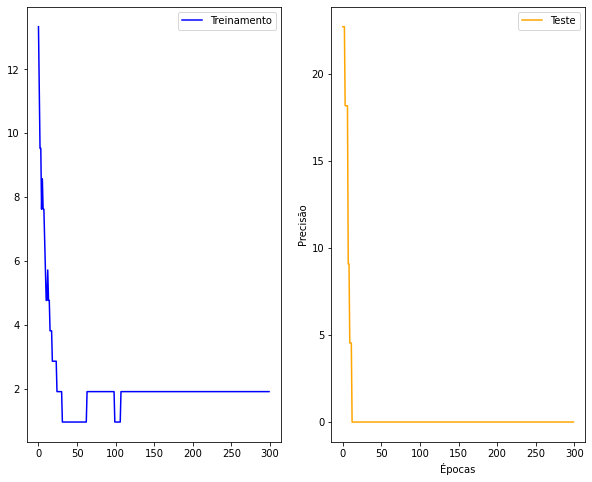

Melhor precisão de treinamento 13.333333333333334
Melhor precisão de teste 22.72727272727273
Melhor precisão de validação 13.043478260869565
Média precisão de treinamento 4.793650793650794
Média precisão de teste 6.212121212121213
Média precisão de validação 2.608695652173913
Desvio Padrão precisão de treinamento 3.8054210711626353
Desvio Padrão precisão de teste 5.9246105442476225
Desvio Padrão precisão de validação 3.984848430396383
Tempo de execução: 64.41784906387329 Segundos


In [105]:
executar_perceptron(funcao_ativacao_step, funcao_custo, 300)

### Resultados iniciais e ZeroR
Os testes inicias mostram uma precisão extremamente baixa, algo está definitivamente se comportando mal no algoritmo. Podemos ter certeza que o culpado é nosso algoritmo e não a base de dados devido a análise exploratória nos dados que foi feita anteriormente, uma vez que as características separáveis dos dados deveriam nos dar uma precisão maior que a encontrada até agora.

Para saber a precisão mínima que o algoritmo deve ter para ser considerado melhor do que não usar algoritmo algum foi utilizado o "zeroR" como critério. A precisão do zeroR, considerado nosso limiar mínimo, é dado pela proporção de registros da classe majoritária no *dataframe*.


Nesse *dataframe* as classes estão **normalmente distribuídas** em 3 partes iguais, fazendo com que a precisão majoritária sem algoritmos seja de **33%**, portanto, qualquer precisão inferior a isso torna o uso do algoritmo injustificável.


Todavia, ainda que nosso algoritmo seja considerado útil com 34% de acerto, ainda está longe de algo desejável.

# Melhorando os resultados
Os passos que seguem foram usados como meio de melhorar a precisão da rede perceptron.

### Função de ativação sigmoid.
Como foi dito anteriormente, utilizar a função degrau para ativação pode ocasionar o aumento dos erros, devido a possibilidade de excitar vários neurônios ao passar pelo limiar especificado. Portanto foi criado uma nova função de ativação sigmoid.

Com isso, os valores ficam em um intervalo de 0 e 1 e o neurônio escolhido para ser excitado é aquele com o maior valor. Dessa forma, já não temos mais o problema de excitar vários neurônios. 

In [100]:
def funcao_ativacao_sigmoid(soma):
    valor_ativacao = list(1 / (1 + math.e ** -soma))
    index_excitacao = valor_ativacao.index(max(valor_ativacao))# pegar neurônio com maior valor  
    neuronio_excitado = [0] * len(soma) # zerar os valores dos neurônios de saída
    neuronio_excitado[index_excitacao] = 1 # definir o valor 1 para o neurônio com maior valor
    
    return neuronio_excitado, valor_ativacao

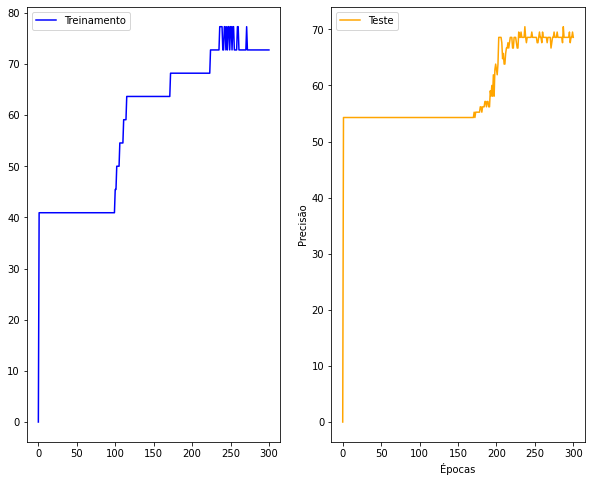

Melhor precisão de treinamento 70.47619047619034
Melhor precisão de teste 77.27272727272728
Melhor precisão de validação 73.91304347826087
Média precisão de treinamento 59.00332225913611
Média precisão de teste 58.7888855330716
Média precisão de validação 30.724637681159425
Desvio Padrão precisão de treinamento 7.299778969303325
Desvio Padrão precisão de teste 14.012900406421016
Desvio Padrão precisão de validação 23.168469690889935
Tempo de execução: 66.21808099746704 Segundos


In [97]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo, 300)

A aplicação da função sigmoid gerou melhorias consideráveis nos resultados.

Um outro parâmetro que pode ser otimizado é o domínio dos pesos, podemos alterar o mesmo para tentar buscar um nível de precisão maior.

Foi observado ao longo do treinamento, que o nosso ótimo global está próximo à valores pequenos de pesos, portanto tiramos vantagem de começar com um domínio próximo a zero e ir evoluindo gradativamente em busca do ótimo global.

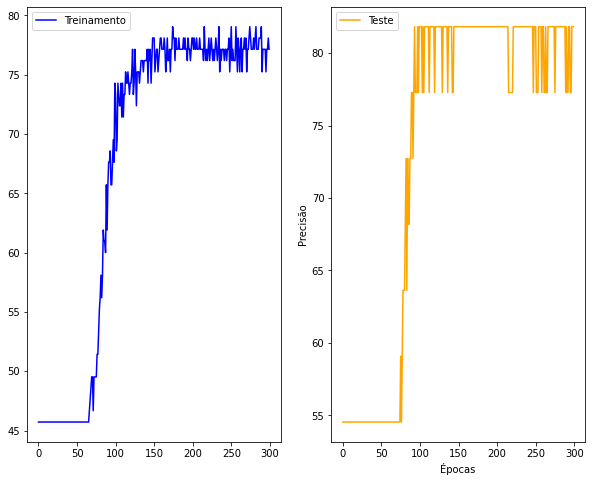

Melhor precisão de treinamento 79.04761904761888
Melhor precisão de teste 81.81818181818183
Melhor precisão de validação 86.95652173913042
Média precisão de treinamento 54.53968253968246
Média precisão de teste 51.96969696969698
Média precisão de validação 51.159420289855085
Desvio Padrão precisão de treinamento 14.535245736027326
Desvio Padrão precisão de teste 18.619110022632512
Desvio Padrão precisão de validação 20.35238810909745
Tempo de execução: 64.77331900596619 Segundos


In [139]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo, 300, [-0.005, 0.005])

Como esperado, utilizar o domínio entre -0.005 e 0.005 acrescentou um ganho de precisão, chegando em torno dos 80%.

## Mean Squared Error e Root Mean Squared error
A função de custo que está sendo utilizada atualmente é a mais simples possível, onde comparamos a diferença entre a previsão atual com o valor esperado. Existem outras fórmulas um pouco mais completas que possuem um nível de precisão maior em estimar os custos.

A primeira delas é a função Mean Squared Error, representada no método *funcao_custo_mse*, que além de calcular o valor correto menos o valor previsto também eleva o resultado da subtração ao quadrado e os soma, gerando um valor escalar que pune mais erros maiores, deixando eles mais expressivos.


A Root Mean Squared Error, representada pelo método *funcao_custo_rmse* segue a mesma formula, porém submetendo os resultados finais a uma raiz quadrada.

In [101]:
def funcao_custo_mse(valor_correto, valor_previsto, valor_ativacao):
    erro = valor_correto != valor_previsto

    valor_erro = list(abs(np.array(valor_correto) - np.array(valor_ativacao)))
    erro_quadratico = list(map(lambda x: math.pow(x, 2), valor_erro))
    soma_erro_quadratico = sum(erro_quadratico)

    return erro, soma_erro_quadratico

In [102]:
def funcao_custo_rmse(valor_correto, valor_previsto, valor_ativacao):
    erro, valor_erro = funcao_custo_mse(valor_correto, valor_previsto, valor_ativacao)

    return erro, math.sqrt(valor_erro)

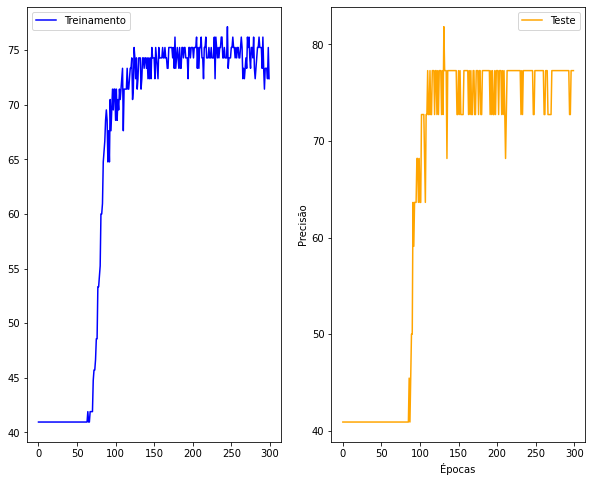

Melhor precisão de treinamento 77.14285714285698
Melhor precisão de teste 81.81818181818183
Melhor precisão de validação 82.6086956521739
Média precisão de treinamento 50.57142857142849
Média precisão de teste 50.60606060606062
Média precisão de validação 47.826086956521735
Desvio Padrão precisão de treinamento 20.275278633309828
Desvio Padrão precisão de teste 22.809950626131897
Desvio Padrão precisão de validação 21.329473500852444
Tempo de execução: 60.76145005226135 Segundos


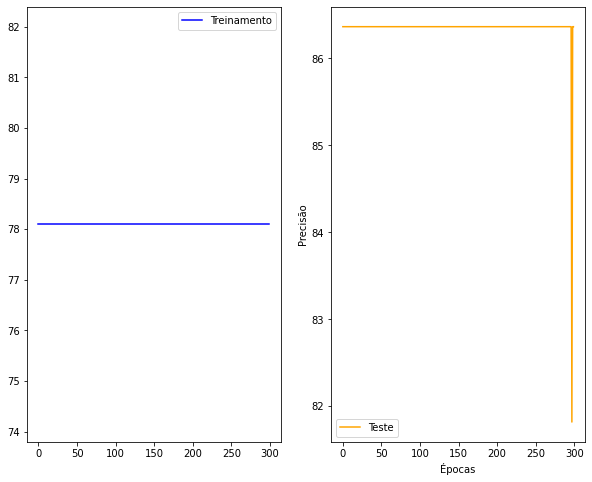

Melhor precisão de treinamento 78.09523809523793
Melhor precisão de teste 86.36363636363637
Melhor precisão de validação 82.6086956521739
Média precisão de treinamento 47.30158730158724
Média precisão de teste 48.78787878787879
Média precisão de validação 44.34782608695652
Desvio Padrão precisão de treinamento 18.159174153746097
Desvio Padrão precisão de teste 18.55426607859592
Desvio Padrão precisão de validação 19.968469159014305
Tempo de execução: 61.97188711166382 Segundos


In [140]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo_mse, 300, [-0.005, 0.005])
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo_rmse, 300, [-0.005, 0.005])

As duas funções se saíram bem na busca dos resultados.

Como é possível perceber, as redes perceptron ainda que consideradas simples, possuem um conjunto grande de parâmetros a serem otimizados, que fazem toda diferença para conseguir atingir o ponto global.

## Problema do gradiente explodindo ou desaparecendo
Um problema enfrentado foi o dos pesos explodindo ou sumindo. No primeiro caso, o valor dos pesos aumentava de forma exponencial, chegando a valores próximos dos 2000 mil por conexão sináptica. Isso gerou uma deteorização na precisão, fazendo com que os valores iniciais da rede sejam sempre os mais altos.

Já no gradiente sumindo, o problema foi uma taxa de aprendizado e um conjunto de pesos muito pequeno, fazendo com que a rede se mantenha uma linha reta, incapaz de aprender nada.

Para resolver esse problema foram feitos vários testes de diferentes pesos e taxas de aprendizado a fim de conseguir chegar a um meio termo. A taxa de aprendizado que melhor se desempenhou foi de 0.001 e um conjunto de pesos entre -0.005 e 0.005.

# Atualização dos pesos por época
As redes neurais multicamadas atualizam os pesos da rede após passar todos os registros pela rede, ou pelo menos uma parte dos registros (batch). A atualização por época faz muito mais sentido, pois a rede é menos afetada por registros ruidosos no *dataframe* além de garantir maior velocidade de processamento por não depender de tantos loops.

Pensando nisso, foi implementado uma versão que trabalha por épocas da rede perceptron. Foram necessárias algumas mudanças nos métodos já apresentados anteriormente.

Primeiro, os valores de classe e previsores foram reiniciados.

In [107]:
previsores = dataframe.iloc[:, 0:4] 
previsores = previsores.apply(lambda row: normalizacao_z_score(row))
previsores['bias'] = 1
classe = dataframe['class']
classe = classe.apply(lambda row: transformar_categorico_em_numerico(row, dict_classes))

Isso é necessário pois a classe foi codificada em um novo formato de matriz ao invés de array, para trabalhar com as operações matemáticas de uma vez só em todos os registros. Para isso, foram feitas alterações no método de *codificar_classe*. 

In [108]:
def codificar_classe_epoca():
    classe_codificada = {}
    
    array_classe = np.array([[1]  + ([0] * (len(classe.unique()) - 1)) ]) # estrutura de matriz
        
    count = 1
    classe_codificada[0] = array_classe.copy()

    for i in range(len(classe.unique()) - 1):
        array_classe[0][count - 1] = 0
        array_classe[0][count] = 1  
        classe_codificada[count] = array_classe.copy()
        count += 1
    
    return classe_codificada

Uma vez criado a estrutura de classe por matriz, criamos a variável *classe_nova* que vai transformar todas as classes do problema no formato de matriz.

In [109]:
classe_codificada = codificar_classe_epoca()
classe_nova = []

for i in classe: # percorre as classes do dataframe
    classe_nova.append(classe_codificada[i])
    
classe_nova = np.array(classe_nova).reshape(len(classe), 3) # redimensiona para criar a matriz
print(classe_nova.shape)

(150, 3)


A classe agora, ao invés de um array [0,1,0] é uma matriz com três colunas, uma para cada posição do array, como podemos ver no *print* do método *shape*, nos indicando as 150 linhas (registros) e três colunas (quantidade de classes).

Foi feita uma pequena modificação no método *dividir_dataframe*, no retorno da classe.
Os métodos que são modificados para executar nesse novo modelo recebem o sulfixo _epoca.

A função sigmoid também recebe algumas modificações de sintax, pois ao invés de pegar o valor máximo de apenas um array e excitá-lo, o processo é feito de uma vez só no conjunto inteiro. 

In [47]:
def funcao_ativacao_sigmoid_epoca(soma):
    valor_ativacao = 1 / (1 + math.e ** -soma)
    index_excitacao = np.argmax(valor_ativacao, 1) 
    
    count = 0
    neuronios_excitado = valor_ativacao.copy()

    for i in index_excitacao:
        neuronios_excitado[count] = 0
        neuronios_excitado[count][i] = 1
        count += 1
        
    return neuronios_excitado, valor_ativacao

A função de custo utilizada foi a de Mean Squared Error, pois mostrou um bom desempenho nos testes. Foram feitas algumas pequenas adaptações para trabalhar com a operação matemática em todos os registros, mas a principal diferença é que na atualização por época, ao invés de contabilizar a precisão incrementalmente, ela é calculada de uma vez só, baseado no número de acertos em todos os registros.

In [38]:
def funcao_custo_mse_epoca(valor_correto, valor_previsto, valor_ativacao):
    erro = list(abs(np.array(valor_correto) - np.array(valor_previsto)))
    valor_erro = list(abs(np.array(valor_correto) - np.array(valor_ativacao)))

    acerto = 0
    for i in erro:
        if sum(i) == 0: # verifica se o registro está correto, ou seja, soma de erro é igual a 0.
            acerto += 1 # incrementa um no acerto

    erro_quadratico = list(map(lambda x: x**2, valor_erro))
    erro_quadratico_medio = sum(erro_quadratico) / len(valor_correto)

    return sum(erro), acerto, sum(erro_quadratico_medio)

A atualização dos pesos é a soma do valor atual do peso com o produto da multiplicação entre taxa de aprendizado, entrada e erro. Nesse caso, como trabalhamos com todas as entradas de uma vez só, é feito a média desse produto.

A vantagem aqui é que os pesos serão atualizados apenas uma vez por época, porém a atualização ainda é individual, ou seja, é considerado o valor médio das entradas de cada neurônio para fazer a atualização.

In [39]:
def atualizar_peso_epoca(entrada, peso, erro, tx_aprendizado):
    novo_peso = peso + np.mean((tx_aprendizado * entrada * erro))
    return novo_peso

O método de testar fica mais simplificado, pois não precisa de loops em cada registro, além de já obter os acertos na própria função de ativação

In [40]:
def testar_epoca(pesos, x_previsores, y_classe, f_ativacao, f_custo):
    entradas = x_previsores.values  
    soma = somatoria(entradas, pesos)
    
    neuronio_excitado, valor_ativacao = f_ativacao(soma)
    
    erro, acertos, valor_erro = f_custo(y_classe, neuronio_excitado, valor_ativacao)
       
    return acertos / len(x_previsores)

Assim como o teste, o treinamento acaba ficando mais simples, lidando com todos os dados de uma vez só

In [41]:
def treinar_epoca(epocas, f_ativacao, f_custo, pesos, x_treinamento, y_treinamento,
                                     x_teste, y_teste, tx_aprendizado):
    execucoes = 0
    precisoes_treinamento = []
    precisoes_teste = []
    melhores_pesos = []
    
    while execucoes < epocas:

        entradas = x_treinamento.values   
        soma = somatoria(entradas, pesos)
    
        neuronio_excitado, valor_ativacao = f_ativacao(soma)
    
        erro, acertos, valor_erro = f_custo(y_treinamento, neuronio_excitado, valor_ativacao)
    
        count = 0
        precisoes_treinamento.append(acertos / len(x_treinamento))    
        melhores_pesos = pesos.copy() if precisoes_treinamento[execucoes] >= max(precisoes_treinamento) else melhores_pesos

        for i in range(entradas.shape[1]): # o for tem que atualizar cada peso da camada
            if i == 4:
                novo_peso = atualizar_bias(entradas[:, i], pesos[i], valor_erro, tx_aprendizado)
            else:
                novo_peso = atualizar_peso_epoca(entradas[:, i], pesos[i], valor_erro, tx_aprendizado)
            pesos[count] = novo_peso
            count += 1
        
        precisoes_teste.append(testar_epoca(pesos, x_teste, y_teste, f_ativacao, f_custo))
        execucoes += 1
    
    return precisoes_treinamento, precisoes_teste, melhores_pesos

O novo método de executar perceptron vai chamar todos os novos métodos que criamos e executar nossa rede por épocas.

In [60]:
def executar_perceptron_epoca(funcao_ativacao, funcao_custo, epocas, dominio_pesos = [0, 1], 
                        tx_aprendizado = 0.1, exibir_resultados = True):

    convergencia_treinamento = [0]
    convergencia_teste = [0]
    precisao_treinamento = []
    precisao_teste = []
    resultado_final = []
    start_time = time.time()

    for i in range(30):
        pesos = inicializar_pesos(dominio_pesos) # Alterando os pesos em cada inicialização
        x_treinamento, y_treinamento, x_teste, y_teste, x_validacao, y_validacao = dividir_dataframe(previsores, classe_nova, 0.7, 0.15, 0.15, True)

        treinamento = treinar_epoca(epocas, funcao_ativacao, funcao_custo, pesos, x_treinamento, y_treinamento, x_teste, y_teste, tx_aprendizado)
                                     
        convergencia_treinamento = treinamento[0] if max(treinamento[0]) >= \
                                max(convergencia_treinamento) else convergencia_treinamento
        convergencia_teste = treinamento[1] if max(treinamento[1]) >= max(convergencia_teste) \
                                        else convergencia_teste
        
        precisao_treinamento.append(max(treinamento[0]))
        precisao_teste.append(max(treinamento[1]))
        resultado_final.append(testar_epoca(treinamento[2], x_validacao, y_validacao, 
                                      funcao_ativacao, funcao_custo))

        if exibir_resultados == True:
        plotar_convergencia(convergencia_treinamento, convergencia_teste)   
        exibir_resultados(precisao_treinamento, precisao_teste, resultado_final)
        print("Tempo de execução: %s Segundos" % (time.time() - start_time))
        
    return max(precisao_treinamento), max(precisao_teste), max(resultado_final)

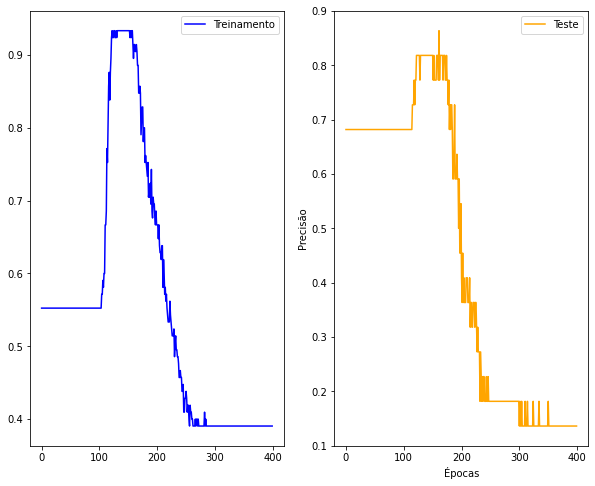

Melhor precisão de treinamento 0.9333333333333333
Melhor precisão de teste 0.8636363636363636
Melhor precisão de validação 0.9565217391304348
Média precisão de treinamento 0.4828571428571429
Média precisão de teste 0.503030303030303
Média precisão de validação 0.5115942028985506
Desvio Padrão precisão de treinamento 0.15949940585667363
Desvio Padrão precisão de teste 0.1574300025195217
Desvio Padrão precisão de validação 0.16752143758961088
Tempo de execução: 13.431392431259155 Segundos


In [62]:
executar_perceptron_epoca(funcao_ativacao_sigmoid_epoca, funcao_custo_mse_epoca, 400, [-0.0005, 0.0005])

## Resultados do treinamento por época
Os resultados de precisão foram bons, chegando em torno dos 90% no teste da rede neural. 
Nesse caso, os resultados não foram tão diferentes do que executar o perceptron e atualizar os pesos por registro individual, mas aqui valem dois pontos de atenção. O primeiro é que a base de dados da iris não é de um problema muito complexo, além de ter uma quantidade pequena e separável de atributos, portanto atualizar olhando para atributos individualmente ou para todos os atributos de uma vez não fez tanta diferença. O segundo é que, como esperado, a execução do algoritmo por épocas conseguiu se sair até 6 vezes mais rápido do que o anterior, levando menos de 20 segundos para finalizar todas as execuções. Essa velocidade de processamento no possibilita testar uma combinação maior de hiperparâmetros, favorecendo a otimização da rede neural.

# Qual o problema?
Utilizar a base de dados de vinhos contidos aqui: http://archive.ics.uci.edu/ml/datasets/Wine para prever qual o tipo de vinha (1, 2 ou 3) baseado nas suas características.

## Anásile exploratória dos dados
Conhecendo um pouco mais dos dados da base de dados.

In [110]:
dataframe = pd.read_csv('/home/alvaro/Documentos/mestrado/computação bio/redes neurais/datasets/wine.csv', header = 0)
dataframe.head()

,Wine,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [111]:
print('Valores nulos:')
print(dataframe.isna().sum())
dataframe.describe()

Valores nulos:
Wine                    0
Alcohol                 0
Malic acid              0
Ash                     0
Alcalinity of ash       0
Magnesium               0
Total phenols           0
Flavanoids              0
Nonflavanoid phenols    0
Proanthocyanins         0
Color intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64


,Wine,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Nesse *dataset* todos os atributos são contínuos, inclusive a classe. Podemos notar que não existe nenhum valor vazio bem como aparentemente nenhum outlier/ruído.

## Normalização dos dados 
Assim como no problema da iris, esse dataset também precisa ser normalizando, ainda mais por conter uma quantidade maior de atributos previsores contínuos.

In [112]:
previsores = dataframe.iloc[:, 1:14] 
classe = dataframe['Wine']

In [113]:
previsores = previsores.apply(lambda row: normalizacao_z_score(row))
previsores.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
0,1.514341,-0.560668,0.231400,-1.166303,1.908522,0.806722,1.031908,-0.657708,1.221438,0.251009,0.361158,1.842721,1.010159
1,0.245597,-0.498009,-0.825667,-2.483841,0.018094,0.567048,0.731565,-0.818411,-0.543189,-0.292496,0.404908,1.110317,0.962526
2,0.196325,0.021172,1.106214,-0.267982,0.088110,0.806722,1.212114,-0.497005,2.129959,0.268263,0.317409,0.786369,1.391224
3,1.686791,-0.345835,0.486554,-0.806975,0.928300,2.484437,1.462399,-0.979113,1.029251,1.182732,-0.426341,1.180741,2.328007
4,0.294868,0.227053,1.835226,0.450674,1.278379,0.806722,0.661485,0.226158,0.400275,-0.318377,0.361158,0.448336,-0.037767


A classe do tipo de vinho é distribuída em 1, 2 e 3, todavia para que meu método de codificar funcione ele precisa começar em 0, por isso, a classe de vinho foi submetida ao método de *transformar_categorico_em_numerico*, que vai transformá-la na sequência de 0, 1 e 2.

In [114]:
dict_classes = get_dicionario_classes(classe)
classe = classe.apply(lambda row: transformar_categorico_em_numerico(row, dict_classes))
classe.value_counts()

1    71
0    59
2    48
Name: Wine, dtype: int64

Agora a classe vai ser codificada em uma array assim como aconteceu com a iris, pois temos novamente um problema do tipo multi-classe.

In [115]:
classe_codificada = codificar_classe()
classe = classe.apply(lambda row: substituir_classe_codificada(row, classe_codificada))
classe.head()

0    [1, 0, 0]
1    [1, 0, 0]
2    [1, 0, 0]
3    [1, 0, 0]
4    [1, 0, 0]
Name: Wine, dtype: object

Agora basta adicionar o neurônio na camada de entrada para ser o bias e executar o perceptron novamente para conferir os resultados da rede.

In [116]:
previsores['bias'] = 1

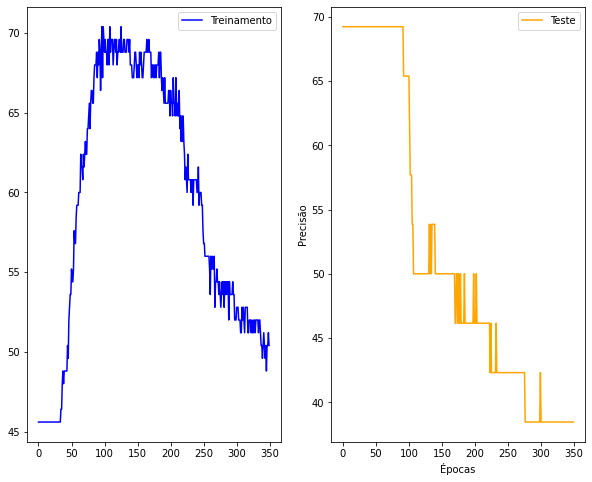

Melhor precisão de treinamento 70.39999999999988
Melhor precisão de teste 69.23076923076923
Melhor precisão de validação 66.66666666666666
Média precisão de treinamento 38.93333333333331
Média precisão de teste 40.641025641025635
Média precisão de validação 37.90123456790123
Desvio Padrão precisão de treinamento 15.574794452005493
Desvio Padrão precisão de teste 17.644398157057847
Desvio Padrão precisão de validação 17.178248209672507
Tempo de execução: 99.26646423339844 Segundos


In [117]:
executar_perceptron(funcao_ativacao_sigmoid, funcao_custo_mse, 350, [-0.005, 0.005])

Agora o processo de leitura dos dados e pré-processamento deve ser repetido, porém agora de maneira um pouco diferente, para adequar os dados à rede perceptron por épocas, assim como foi feito anteriormente no problema das iris

In [121]:
previsores = dataframe.iloc[:, 1:14] 
classe = dataframe['Wine']
previsores = previsores.apply(lambda row: normalizacao_z_score(row))

dict_classes = get_dicionario_classes(classe)
classe = classe.apply(lambda row: transformar_categorico_em_numerico(row, dict_classes))
classe_codificada = codificar_classe_epoca()

classe_nova = []

for i in classe:
    classe_nova.append(classe_codificada[i])
    
classe_nova = np.array(classe_nova).reshape(len(classe), 3)

previsores['bias'] = 1

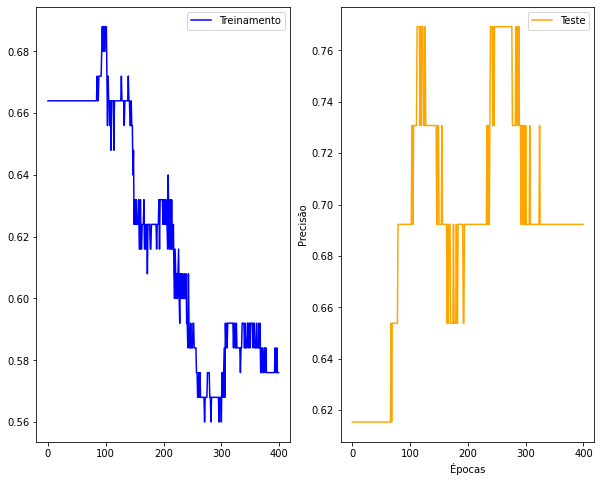

Melhor precisão de treinamento 0.688
Melhor precisão de teste 0.7692307692307693
Melhor precisão de validação 0.8148148148148148
Média precisão de treinamento 0.4538666666666666
Média precisão de teste 0.5076923076923078
Média precisão de validação 0.4530864197530864
Desvio Padrão precisão de treinamento 0.09060233011475048
Desvio Padrão precisão de teste 0.1155554291204487
Desvio Padrão precisão de validação 0.14366148461315545
Tempo de execução: 15.721159934997559 Segundos


In [127]:
executar_perceptron_epoca(funcao_ativacao_sigmoid_epoca, funcao_custo_mse_epoca, 400, [-0.005, 0.005])

A rede perceptron, ainda que bastante simples, conseguiu resultados interessantes nesse problema considerado mais complexo, devido ao maior número de atributos previsores.

# Encontrando os melhores resultados
Existem algumas formas de encontrar os melhores resultados que um determinado algoritmo pode proporcionar. Uma delas é pelo teste exaustivo de parâmetros, onde são testados todas as combinações de parâmetros a fim de encontrar os melhores resultados.

Algoritmos como as redes neurais que possuem um quantidade maior de parâmetros se beneficiam desse tipo de abordagem, todavia o tempo de execução para esses testes muitas das vezes acaba sendo alto.

Para isso, foi criado o método *buscar_parametros*, que recebe um dicionário com uma lista de parâmetros, e cria uma lista com todos os parâmetros combinados.

Após isso, cada elemento da lista é executado, representando uma diferente possibilidade de combinação de parâmetros. Essa combinação é executada por 30 vezes no método *executar_perceptron*.

Ao final de todas as iterações, vamos ter os resultados finais obtidos bem como os melhores parâmetros para o algoritmo .

In [ ]:
def buscar_parametros(lista_parametros, executar):
    # cria uma única lista com todos os parâmetros
    parametros = [lista_parametros['custo'],
    lista_parametros['tx_aprendizado'], lista_parametros['pesos']]
    
    # Combinação de cada um desses parâmetros
    combinacao_parametros = list(itertools.product(*parametros))

    melhores_parametros = []
    melhor_precisao_teste = 0
    melhor_precisao_treinamento = 0
    melhor_precisao_validacao = 0
    # nesse for os parâmetros são testados
    for i in combinacao_parametros:
        precisao_treinamento, precisao_teste, resultado_final = executar(funcao_ativacao_sigmoid, i[0], 400, [-i[2], i[2]], i[1])
        # pegando os melhores resultados
        if resultado_final >= melhor_precisao_validacao:
            melhor_precisao_teste = precisao_teste
            melhor_precisao_treinamento = precisao_treinamento
            melhor_precisao_validacao = resultado_final
            melhores_parametros = i

    return melhores_parametros, melhor_precisao_teste, melhor_precisao_treinamento, melhor_precisao_validacao

In [ ]:
lista_parametros_epoca = { 'custo' : [funcao_custo, funcao_custo_mse],
                      'tx_aprendizado': [0.1, 0.01, 0.0001],
                      'pesos': [0.5, 0.05, 0.005, 0.0005]
}

lista_parametros = { 'custo' : [funcao_custo, funcao_custo_mse, funcao_custo_rmse],
                      'tx_aprendizado': [0.1, 0.01, 0.0001],
                      'pesos': [0.5, 0.05, 0.005, 0.0005]
}

In [ ]:
teste_parametrico = buscar_parametros(lista_parametros, executar_perceptron)
print('Melhores parâmetros', teste_parametrico[0])
print('Melhor precisão teste', teste_parametrico[1])
print('Melhor precisão treinamento', teste_parametrico[2])
print('Melhor precisão validação', teste_parametrico[3])

In [ ]:
teste_parametrico = buscar_parametros(lista_parametros, executar_perceptron_epoca)
print('Melhores parâmetros', teste_parametrico[0])
print('Melhor precisão teste', teste_parametrico[1])
print('Melhor precisão treinamento', teste_parametrico[2])
print('Melhor precisão validação', teste_parametrico[3])

# Qual o problema?
Selecionar conjunto da escolha